# Reference for this code:
After attempting multiple different network models, we were finally able to find some major online help to apply our dataset on a new model that ended up working. The code below still uses OpenCV but adds PIL image to read and process all images. It then applies a General Adversarial Network (GAN) with a UNet Network as the generator, and a discriminator network to combine the predicted channels from the UNet network and determine if the image is real or fake based-upon labels given.

Majority of this model and the methods/code used were found in the Towards Data Science. There are still some aspects of the code that we tried to preserve from our previous iterations of work such as using OpenCV, batch normalization, ReLU, and the overall approach of a CNN. The full citation and retrieval information can be found in the citation below.

Shariatnia, M (2020, November 18). Colorizing black and white images with U-Net and conditional GAN: A tutorial. Towards Data Science. Retrieved December 3, 2024, from https://towardsdatascience.com/colorizing-black-white-images-with-u-net-and-conditional-gan-a-tutorial-81b2df111cd8


In [61]:
import cv2
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
from torchvision.transforms import InterpolationMode
from torchvision.utils import make_grid
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader
from glob import glob
from skimage.color import rgb2lab, lab2rgb
from sklearn.model_selection import train_test_split

## Defining Data Paths, Grabbing Images to Train and Test

In [ ]:
COLOR_TRAIN_DIR = "data/train_color"
BLACK_TRAIN_DIR = "data/train_black"
COLOR_TEST_DIR = "data/test_color2" # Right now
BLACK_TEST_DIR = "data/test_black2"
IMG_SIZE = 256 #images are 400x400 ---- Make them smaller to use less memory but keep accuracy
BATCH_SIZE = 16 # hyperparameter we need to optimize - 16 working fine for now
EPOCHS = 50
NUMBER_OF_IMAGES = 5000
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

trainPaths = glob(COLOR_TRAIN_DIR + "/*.jpg")
testPaths = glob(COLOR_TEST_DIR + "/*.jpg")

trainPaths = np.random.choice(trainPaths, NUMBER_OF_IMAGES, replace=False) # chooses images in random order
trainPaths, valPaths = train_test_split(trainPaths, test_size=0.1, random_state=42)

print(len(trainPaths), len(testPaths), len(valPaths))

80 3 20


In [63]:
class ColorizationDataset(Dataset):
    def __init__(self, paths, split='train'):
        if split == 'train':
            self.transforms = transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize((IMG_SIZE, IMG_SIZE), interpolation=transforms.InterpolationMode.BICUBIC),
                transforms.RandomHorizontalFlip(), # Add in data augmentation if it is in training mode
                transforms.ToTensor()
            ])
        elif split == 'val' or split == 'test':
            self.transforms = transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize((IMG_SIZE, IMG_SIZE), interpolation=transforms.InterpolationMode.BICUBIC),
                transforms.ToTensor()
            ])
        
        self.split = split
        self.size = IMG_SIZE
        self.paths = paths
    
    def __getitem__(self, idx):
        # Use OpenCV to read images
        img = cv2.imread(self.paths[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Apply transforms depending on the mode, need to also conver to PIL image here
        if self.transforms:
            img = self.transforms(img).numpy().transpose(1, 2, 0)
        
        # Convert rgb into lab
        labImage = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
        
        # Normalize all lab channels between -1 and 1
        L = labImage[:,:,0] / 50. - 1.
        ab = labImage[:,:,1:] / 110.
        
        # Convert to tensors before returning
        L = torch.from_numpy(L).unsqueeze(0)
        ab = torch.from_numpy(ab).permute(2, 0, 1)
        
        return {'L': L, 'ab': ab}
    
    def __len__(self):
        return len(self.paths)

In [64]:
def loadData(batch_size=BATCH_SIZE, pin_memory=True, **kwargs):
    dataset = ColorizationDataset(**kwargs)
    dataloader = DataLoader(dataset, batch_size=batch_size, pin_memory=pin_memory)
    return dataloader

loadedTraining = loadData(paths=trainPaths, split='train')
loadedVal = loadData(paths=valPaths, split='val')
loadedTest = loadData(paths=testPaths, split='test')

In [65]:
class UnetBlock(nn.Module):
    def __init__(self, nf, ni, submodule=None, input_c=None, dropout=False,
                 innermost=False, outermost=False):
        super().__init__()
        self.outermost = outermost
        if input_c is None: input_c = nf
        downconv = nn.Conv2d(input_c, ni, kernel_size=4,
                             stride=2, padding=1, bias=False)
        downrelu = nn.LeakyReLU(0.2, True)
        downnorm = nn.BatchNorm2d(ni)
        uprelu = nn.ReLU(True)
        upnorm = nn.BatchNorm2d(nf)
        
        if outermost:
            upconv = nn.ConvTranspose2d(ni * 2, nf, kernel_size=4,
                                        stride=2, padding=1)
            down = [downconv]
            up = [uprelu, upconv, nn.Tanh()]
            model = down + [submodule] + up
        elif innermost:
            upconv = nn.ConvTranspose2d(ni, nf, kernel_size=4,
                                        stride=2, padding=1, bias=False)
            down = [downrelu, downconv]
            up = [uprelu, upconv, upnorm]
            model = down + up
        else:
            upconv = nn.ConvTranspose2d(ni * 2, nf, kernel_size=4,
                                        stride=2, padding=1, bias=False)
            down = [downrelu, downconv, downnorm]
            up = [uprelu, upconv, upnorm]
            if dropout: up += [nn.Dropout(0.5)]
            model = down + [submodule] + up
        self.model = nn.Sequential(*model)
    
    def forward(self, x):
        if self.outermost:
            return self.model(x)
        else:
            return torch.cat([x, self.model(x)], 1)

class Unet(nn.Module):
    def __init__(self, input_c=1, output_c=2, n_down=8, num_filters=64):
        super().__init__()
        unet_block = UnetBlock(num_filters * 8, num_filters * 8, innermost=True)
        for _ in range(n_down - 5):
            unet_block = UnetBlock(num_filters * 8, num_filters * 8, submodule=unet_block, dropout=True)
        out_filters = num_filters * 8
        for _ in range(3):
            unet_block = UnetBlock(out_filters // 2, out_filters, submodule=unet_block)
            out_filters //= 2
        self.model = UnetBlock(output_c, out_filters, input_c=input_c, submodule=unet_block, outermost=True)
    
    def forward(self, x):
        return self.model(x)

In [66]:
class PatchDiscriminator(nn.Module):
    def __init__(self, input_c, num_filters=64, n_down=3):
        super().__init__()
        model = [self.get_layers(input_c, num_filters, norm=False)]
        # the 'if' statement is taking care of not using stride of 2 for the last block in this loop so dimension size isn't altered
        model += [self.get_layers(num_filters * 2 ** i, num_filters * 2 ** (i + 1), s=1 if i == (n_down-1) else 2) for i in range(n_down)] 
        model += [self.get_layers(num_filters * 2 ** n_down, 1, s=1, norm=False, act=False)] # Make sure to not use normalization or activation here
        self.model = nn.Sequential(*model)                                                   
        
    def get_layers(self, ni, nf, k=4, s=2, p=1, norm=True, act=True): # when needing to make some repeatitive blocks of layers,
        layers = [nn.Conv2d(ni, nf, k, s, p, bias=not norm)]          # it's always helpful to make a separate method for that purpose
        if norm: layers += [nn.BatchNorm2d(nf)]
        if act: layers += [nn.LeakyReLU(0.2, True)]
        return nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

In [67]:
class GANLoss(nn.Module):
    def __init__(self, real_label=1.0, fake_label=0.0):
        super().__init__()
        # Makes tensor of either 0's or 1's depending on real or fake label
        self.register_buffer('real_label', torch.tensor(real_label))
        self.register_buffer('fake_label', torch.tensor(fake_label))
        # Uses Binary Cross Entropy Loss since we are dealing with binary classiication for real or fake images
        self.loss = nn.BCEWithLogitsLoss()
    
    def get_labels(self, preds, target_is_real):
        if target_is_real:
            labels = self.real_label
        else:
            labels = self.fake_label
        return labels.expand_as(preds)
    
    def __call__(self, preds, target_is_real):
        labels = self.get_labels(preds, target_is_real)
        loss = self.loss(preds, labels)
        return loss

In [68]:
# Function to initialize weights of model with mean of 0.0 and standard deviation of 0.02 which are hyperparam values
def init_weights(net, gain=0.02):
    def init_func(m):
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and 'Conv' in classname:
            nn.init.normal_(m.weight.data, mean=0.0, std=gain)
            if hasattr(m, 'bias') and m.bias is not None:
                nn.init.constant_(m.bias.data, 0.0)
        elif 'BatchNorm2d' in classname:
            nn.init.normal_(m.weight.data, 1., gain)
            nn.init.constant_(m.bias.data, 0.)
            
    net.apply(init_func)
    return net

def init_model(model, device):
    model = model.to(device)
    model = init_weights(model)
    return model

In [69]:
class MainModel(nn.Module):
    def __init__(self, lr_G=2e-4, lr_D=2e-4, 
                 beta1=0.5, beta2=0.999, lambda_L1=100.):
        super().__init__()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.lambda_L1 = lambda_L1
        self.genNetwork = init_model(Unet(input_c=1, output_c=2, n_down=8, num_filters=64), self.device)
        self.discrimNetwork = init_model(PatchDiscriminator(input_c=3, n_down=3, num_filters=64), self.device)
        self.GANcriterion = GANLoss().to(self.device)
        self.L1criterion = nn.L1Loss()
        self.opt_G = optim.Adam(self.genNetwork.parameters(), lr=lr_G, betas=(beta1, beta2))
        self.opt_D = optim.Adam(self.discrimNetwork.parameters(), lr=lr_D, betas=(beta1, beta2))
    
    def set_requires_grad(self, model, requires_grad=True):
        for p in model.parameters():
            p.requires_grad = requires_grad
        
    def setup_input(self, data):
        self.L = data['L'].to(self.device)
        self.ab = data['ab'].to(self.device)
        
    def forward(self):
        self.fake_color = self.genNetwork(self.L)
        
    def backward_D(self):
        fake_image = torch.cat([self.L, self.fake_color], dim=1)
        fake_preds = self.discrimNetwork(fake_image.detach())
        self.loss_Discriminator_fake = self.GANcriterion(fake_preds, False)
        real_image = torch.cat([self.L, self.ab], dim=1)
        real_preds = self.discrimNetwork(real_image)
        self.loss_Discriminator_real = self.GANcriterion(real_preds, True)
        self.loss_Discriminator = (self.loss_Discriminator_fake + self.loss_Discriminator_real) * 0.5
        self.loss_Discriminator.backward()
    
    def backward_G(self):
        fake_image = torch.cat([self.L, self.fake_color], dim=1)
        fake_preds = self.discrimNetwork(fake_image)
        self.loss_Generator_GAN = self.GANcriterion(fake_preds, True)
        self.loss_Generator_L1 = self.L1criterion(self.fake_color, self.ab) * self.lambda_L1
        self.loss_Generator = self.loss_Generator_GAN + self.loss_Generator_L1
        self.loss_Generator.backward()
    
    def optimize(self):
        # Forward pass and stores fake_color images
        self.forward()
        # Trains discrim network and performs gradient descent on network
        self.discrimNetwork.train()
        self.set_requires_grad(self.discrimNetwork, True)
        self.opt_D.zero_grad()
        # Feeds fake images and labels them as fake, then feeds real images and calculates loss
        self.backward_D()
        self.opt_D.step()
        
        # Now train generator -> feed fake images and label them as real to see if model can learn that it is actually fake
        self.genNetwork.train()
        self.set_requires_grad(self.discrimNetwork, False)
        self.opt_G.zero_grad()
        # Uses L1 loss to compute distance between channels for the backward step of generator
        self.backward_G()
        self.opt_G.step()

In [ ]:
# Describes the discriminator model
PatchDiscriminator(3)

PatchDiscriminator(
  (model): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (3): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (

In [71]:
# Class to update and reset averages, sum, and counts for losses
class AverageMeter:
    def __init__(self):
        self.reset()
        
    def reset(self):
        self.count, self.avg, self.sum = [0.] * 3
    
    def update(self, val, count=1):
        self.count += count
        self.sum += count * val
        self.avg = self.sum / self.count

# Functions for creating and updating all loss values
def create_loss_meters():
    loss_Discriminator_fake = AverageMeter()
    loss_Discriminator_real = AverageMeter()
    loss_Discriminator = AverageMeter()
    loss_Generator_GAN = AverageMeter()
    loss_Generator_L1 = AverageMeter()
    loss_Generator = AverageMeter()
    
    return {'loss_Discriminator_fake': loss_Discriminator_fake,
            'loss_Discriminator_real': loss_Discriminator_real,
            'loss_Discriminator': loss_Discriminator,
            'loss_Generator_GAN': loss_Generator_GAN,
            'loss_Generator_L1': loss_Generator_L1,
            'loss_Generator': loss_Generator}

def update_losses(model, loss_meter_dict, count):
    for loss_name, loss_meter in loss_meter_dict.items():
        loss = getattr(model, loss_name)
        loss_meter.update(loss.item(), count=count)

# Converts lab to rgb and concatenates a single image
def lab_to_rgb(L, ab):
    L = (L + 1.) * 50.
    ab = ab * 110.
    Lab = torch.cat([L, ab], dim=1).permute(0, 2, 3, 1).cpu().numpy()
    rgb_imgs = []
    for img in Lab:
        img_rgb = lab2rgb(img)
        rgb_imgs.append(img_rgb)
    return np.stack(rgb_imgs, axis=0)

def log_results(loss_meter_dict):
    for loss_name, loss_meter in loss_meter_dict.items():
        print(f"{loss_name}: {loss_meter.avg:.5f}")

In [ ]:
# Function from article 
def train_model(model, trainDataLoder, epochs, savedModelPath, display_every=100):
    data = next(iter(loadedVal)) # Going to test the model while training using the test set and predicted output to update our losses
    for e in range(epochs):
        loss_meter_dict = create_loss_meters() # function returing a dictionary of objects to log the losses of the complete network
        i = 0
        for data in tqdm(trainDataLoder):
            model.setup_input(data) 
            model.optimize() # Calls optimize function in MainModel to perform all training for each batch
            update_losses(model, loss_meter_dict, count=data['L'].size(0)) # function updating the log objects
            i += 1
            # Display all updated loss values every so often throughout each epoch
            if i % display_every == 0:
                print(f"\nEpoch {e+1}/{epochs}")
                print(f"Iteration {i}/{len(trainDataLoder)}")
                log_results(loss_meter_dict) # function to print out the losses

    # Save the model at the very end to use for testing on unseen images using the already implemented visualize function
    torch.save(model.state_dict(), savedModelPath)

# Initialize the model, setup a saved path, and then train the model
model = MainModel()
savedModelPath = 'trained_model.pth'
train_model(model, loadedTraining, EPOCHS, savedModelPath)

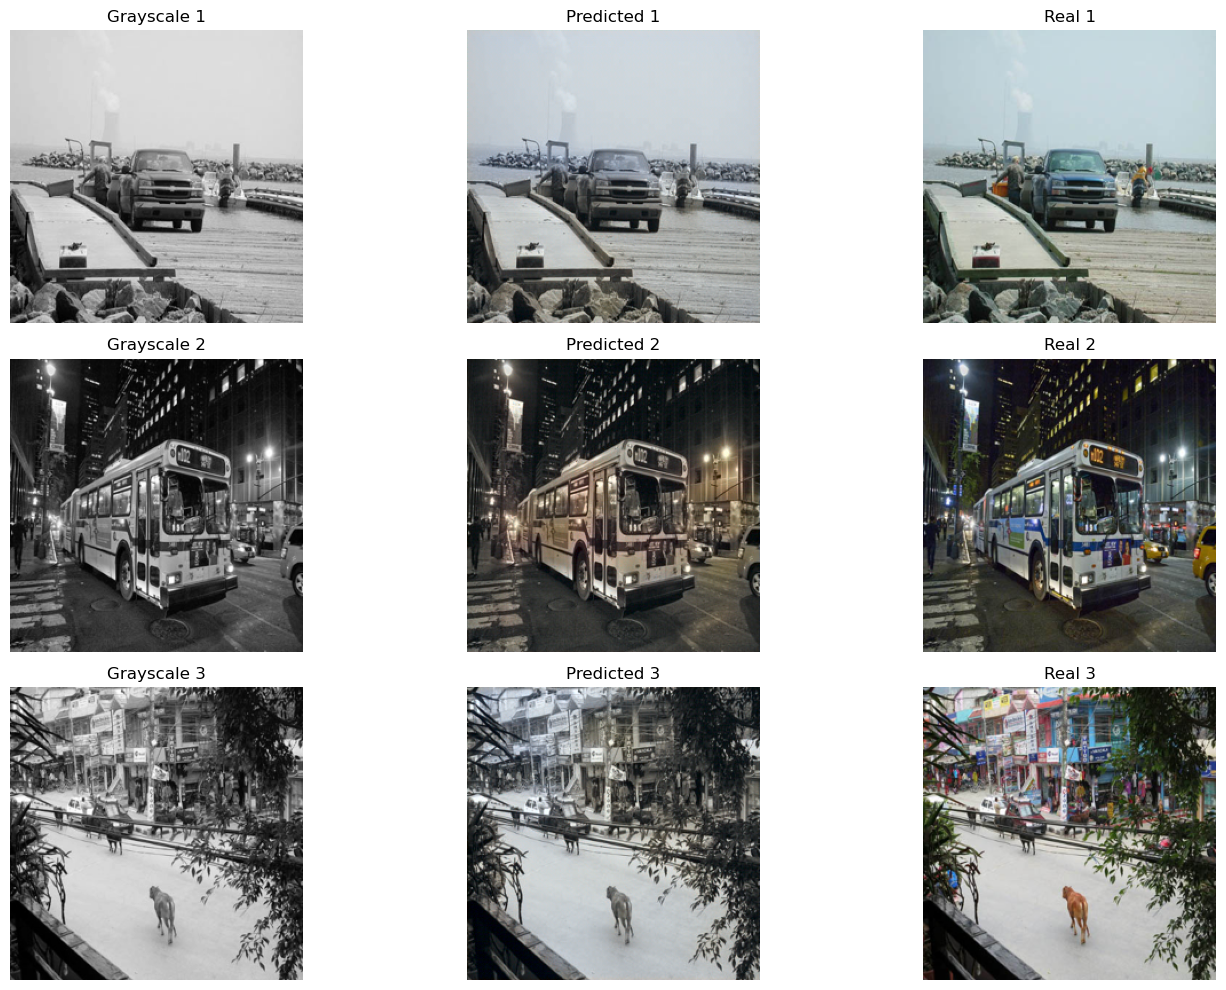

In [103]:
# Function to test the model and visualize all UNSEEN test images to see how the model performs 
def test_model(model, testDataLoader, modelPath, save=False):
    for data in testDataLoader:
        # Using code provided for visualizing and testing the network from article
        model.load_state_dict(torch.load(modelPath))
        model.genNetwork.eval()
        with torch.no_grad():
            model.setup_input(data)
            model.forward()
        model.genNetwork.train()

        # Gets predicted and real image channels
        predictedImage = model.fake_color.detach()
        realImage = model.ab
        L = model.L

        # Concatenates all channels to make a final rgb image for both real and predicted
        predictedImages = lab_to_rgb(L, predictedImage)
        realImages = lab_to_rgb(L, realImage)

        # Create a figure
        fig, axes = plt.subplots(3, len(data) + 1, figsize=(15, 10))  # Create a 3x3 grid
        
        # Loops through rows and columns in each row to output all test images on model
        for row in range(len(data) + 1):
            # Grayscale image
            axes[row, 0].imshow(L[row][0].cpu(), cmap='gray')
            axes[row, 0].set_title(f"Grayscale {row + 1}")
            axes[row, 0].axis("off")
            # Predicted image
            axes[row, 1].imshow(predictedImages[row])
            axes[row, 1].set_title(f"Predicted {row + 1}")
            axes[row, 1].axis("off")
            # Real image
            axes[row, 2].imshow(realImages[row]) 
            axes[row, 2].set_title(f"Real {row + 1}")
            axes[row, 2].axis("off")
        plt.tight_layout()
        plt.show()

        # For if we want to save the plot figure
        if save:
            fig.savefig(f"colorization_{time.time()}.png")
        

test_model(model, loadedTest, savedModelPath)